In [1]:
# Requirements
!pip install numpy matplotlib pandas pillow tqdm torch torchvision scikit-learn kagglehub

In [2]:
# Import
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from PIL import Image
from tqdm import tqdm

import torch
from torch import nn, optim
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights
from torchsummary import summary
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import kagglehub

In [3]:
# Setup for fixing the seed
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
set_seed()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cpu


In [4]:
# Download dataset from KaggleHub
path = kagglehub.dataset_download("phylake1337/fire-dataset")
data_dir = os.path.join(path, "fire_dataset")

print("Dataset Path:", data_dir)
print("Classes:", os.listdir(data_dir))  # ['fire_images', 'non_fire_images']

Dataset Path: C:\Users\anton\.cache\kagglehub\datasets\phylake1337\fire-dataset\versions\1\fire_dataset
Classes: ['fire_images', 'non_fire_images']


In [5]:
# Define Image Transforms
mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(0.2, 0.2, 0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

In [6]:
# Load Full Dataset
full_ds = ImageFolder(data_dir, transform=train_transform)

# Split Dataset (80% train / 20% val)
train_size = int(0.8 * len(full_ds))
val_size = len(full_ds) - train_size
train_ds, val_ds = torch.utils.data.random_split(full_ds, [train_size, val_size])

# Apply validation transform to val_ds
val_ds.dataset.transform = val_transform
class_names = full_ds.classes

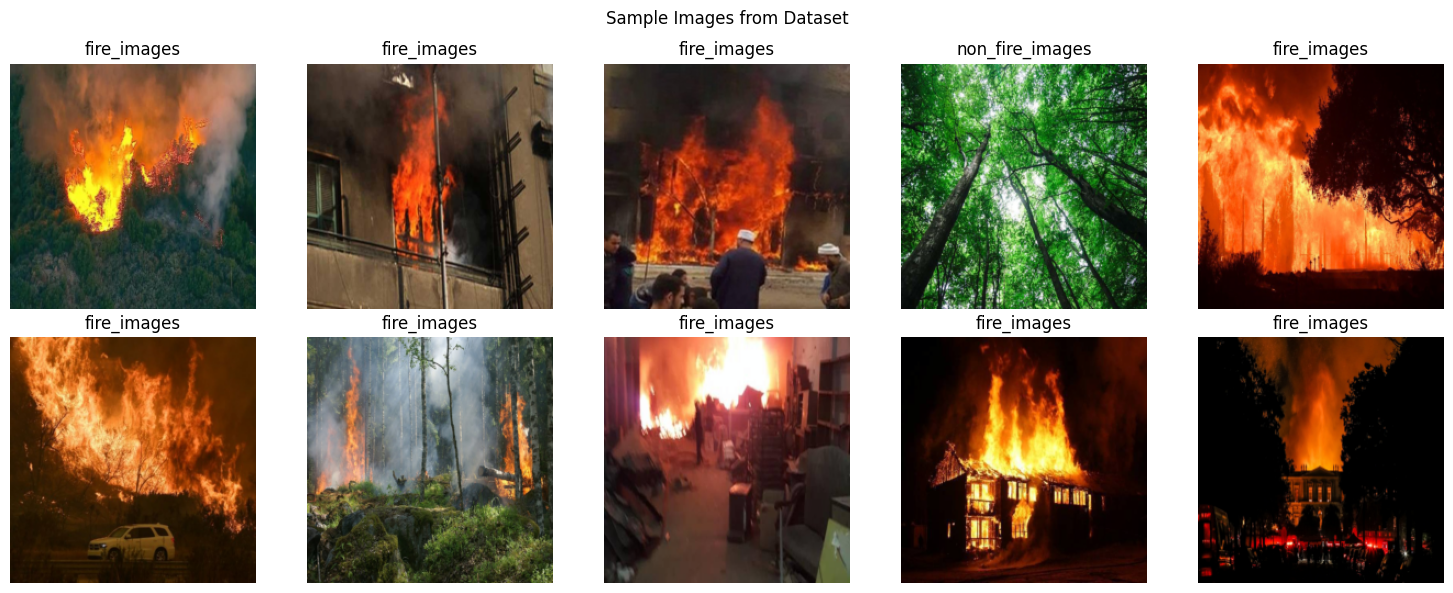

In [7]:
# Show Sample Images from Dataset
def show_samples(dataset, class_names, n=10):
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    for i in range(n):
        img, label = dataset[random.randint(0, len(dataset) - 1)]
        img = img.permute(1, 2, 0).numpy()
        img = np.clip(img * std + mean, 0, 1)
        ax = axes[i // 5, i % 5]
        ax.imshow(img)
        ax.set_title(class_names[label])
        ax.axis("off")
    plt.suptitle("Sample Images from Dataset")
    plt.tight_layout()
    plt.show()

show_samples(full_ds, class_names)

In [8]:
# Class Balancing
targets = [full_ds.targets[i] for i in train_ds.indices]
class_counts = np.bincount(targets)
class_weights = [1.0 / count for count in class_counts]
weights = [class_weights[label] for label in targets]
sampler = WeightedRandomSampler(weights, len(weights), replacement=True)

In [9]:
# DataLoaders
train_loader = DataLoader(train_ds, batch_size=16, sampler=sampler, num_workers=2, pin_memory=False)
val_loader = DataLoader(val_ds, batch_size=16, shuffle=False, num_workers=2, pin_memory=False)

In [10]:
# Model Setup
model = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1)
model.classifier[3] = nn.Linear(model.classifier[3].in_features, len(class_names))
model = model.to(device)

print("Model Summary:")
summary(model, input_size=(3, 224, 224))

Model Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 112, 112]             432
       BatchNorm2d-2         [-1, 16, 112, 112]              32
         Hardswish-3         [-1, 16, 112, 112]               0
            Conv2d-4           [-1, 16, 56, 56]             144
       BatchNorm2d-5           [-1, 16, 56, 56]              32
              ReLU-6           [-1, 16, 56, 56]               0
 AdaptiveAvgPool2d-7             [-1, 16, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             136
              ReLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 16, 1, 1]             144
      Hardsigmoid-11             [-1, 16, 1, 1]               0
SqueezeExcitation-12           [-1, 16, 56, 56]               0
           Conv2d-13           [-1, 16, 56, 56]             256
      BatchNorm2d-14    

In [11]:
# Loss, Optimizer, Scheduler
loss_fn = nn.CrossEntropyLoss(weight=torch.tensor(class_weights).float().to(device))
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3)

In [12]:
# Training Function
def train_model(model, train_loader, val_loader, epochs=30, patience=5):
    wait = 0
    best_val_acc = 0
    history = []

    for epoch in range(1, epochs + 1):
        t0 = time()
        model.train()

        running_loss = 0
        running_correct = 0
        total = 0

        # Training Loop
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch}"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            preds = outputs.argmax(1)
            running_correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / total
        train_acc = running_correct / total

        # Validation Loop
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        y_true, y_pred = [], []

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = loss_fn(outputs, labels)

                val_loss += loss.item() * images.size(0)
                val_correct += (outputs.argmax(1) == labels).sum().item()
                val_total += labels.size(0)
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(outputs.argmax(1).cpu().numpy())

        val_loss /= val_total
        val_acc = val_correct / val_total

        scheduler.step(val_loss)

        # Compute classification metrics
        report = classification_report(y_true, y_pred, target_names=full_ds.classes, output_dict=True)
        precision = report["weighted avg"]["precision"]
        recall = report["weighted avg"]["recall"]
        f1 = report["weighted avg"]["f1-score"]

        history.append([epoch, train_loss, train_acc, val_loss, val_acc, precision, recall, f1])
        print(f"Epoch {epoch} | {time() - t0:.1f}s | "
              f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | F1: {f1:.4f}")

        # Early stopping without saving best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print("Early stopping triggered.")
                break

    # Return training history as DataFrame
    return pd.DataFrame(history, columns=["Epoch", "TrainLoss", "TrainAcc", "ValLoss", "ValAcc", "Precision", "Recall", "F1"])

# Run the training process
log_df = train_model(model, train_loader, val_loader, epochs=30, patience=5)

Epoch 1: 100%|██████████| 50/50 [00:37<00:00,  1.32it/s]


Epoch 1 | 51.4s | Train Acc: 0.7972 | Val Acc: 0.9150 | F1: 0.9187


Epoch 2: 100%|██████████| 50/50 [00:33<00:00,  1.49it/s]


Epoch 2 | 46.7s | Train Acc: 0.9549 | Val Acc: 0.9700 | F1: 0.9702


Epoch 3: 100%|██████████| 50/50 [00:33<00:00,  1.49it/s]


Epoch 3 | 43.3s | Train Acc: 0.9712 | Val Acc: 0.9800 | F1: 0.9800


Epoch 4: 100%|██████████| 50/50 [00:30<00:00,  1.63it/s]


Epoch 4 | 40.5s | Train Acc: 0.9925 | Val Acc: 0.9850 | F1: 0.9851


Epoch 5: 100%|██████████| 50/50 [00:33<00:00,  1.50it/s]


Epoch 5 | 44.0s | Train Acc: 0.9925 | Val Acc: 0.9850 | F1: 0.9849


Epoch 6: 100%|██████████| 50/50 [00:33<00:00,  1.50it/s]


Epoch 6 | 45.1s | Train Acc: 0.9937 | Val Acc: 0.9800 | F1: 0.9800


Epoch 7: 100%|██████████| 50/50 [00:33<00:00,  1.50it/s]


Epoch 7 | 44.6s | Train Acc: 0.9950 | Val Acc: 0.9850 | F1: 0.9849


Epoch 8: 100%|██████████| 50/50 [00:37<00:00,  1.35it/s]


Epoch 8 | 48.2s | Train Acc: 0.9950 | Val Acc: 0.9850 | F1: 0.9849


Epoch 9: 100%|██████████| 50/50 [00:33<00:00,  1.49it/s]


Epoch 9 | 44.2s | Train Acc: 1.0000 | Val Acc: 0.9850 | F1: 0.9849
Early stopping triggered.


In [13]:
# Save the training log for later analysis
log_df.to_csv("training_log.csv", index=False)

# Display first few training results
log_df.head()

Epoch  TrainLoss  TrainAcc   ValLoss  ValAcc  Precision  Recall        F1
0      1   0.353181  0.797247  0.210300   0.915   0.933811   0.915  0.918658
1      2   0.107652  0.954944  0.074586   0.970   0.970684   0.970  0.970214
2      3   0.073779  0.971214  0.059085   0.980   0.980000   0.980  0.980000
3      4   0.034765  0.992491  0.050022   0.985   0.985175   0.985  0.985054
4      5   0.020804  0.992491  0.066655   0.985   0.984956   0.985  0.984944

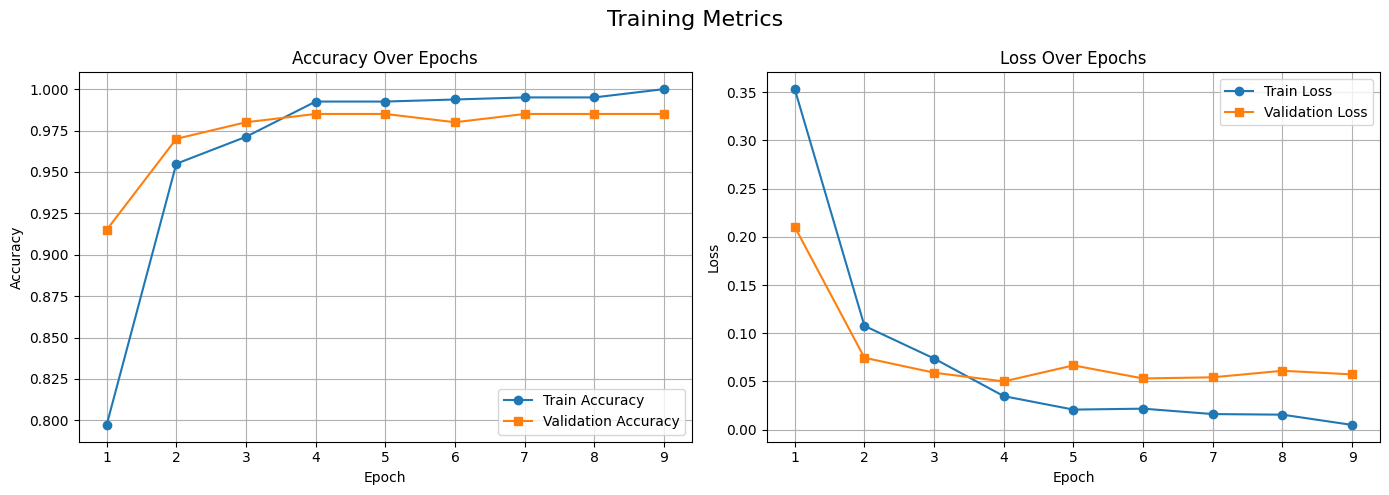

In [14]:
# Plot Accuracy & Loss Curves
def plot_metrics(df):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Accuracy
    axes[0].plot(df["Epoch"], df["TrainAcc"], label="Train Accuracy", marker='o')
    axes[0].plot(df["Epoch"], df["ValAcc"], label="Validation Accuracy", marker='s')
    axes[0].set_title("Accuracy Over Epochs")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Accuracy")
    axes[0].legend()
    axes[0].grid(True)

    # Loss
    axes[1].plot(df["Epoch"], df["TrainLoss"], label="Train Loss", marker='o')
    axes[1].plot(df["Epoch"], df["ValLoss"], label="Validation Loss", marker='s')
    axes[1].set_title("Loss Over Epochs")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Loss")
    axes[1].legend()
    axes[1].grid(True)

    plt.suptitle("Training Metrics", fontsize=16)
    plt.tight_layout()
    plt.show()

# Display metrics
plot_metrics(log_df)

<Figure size 800x600 with 0 Axes>

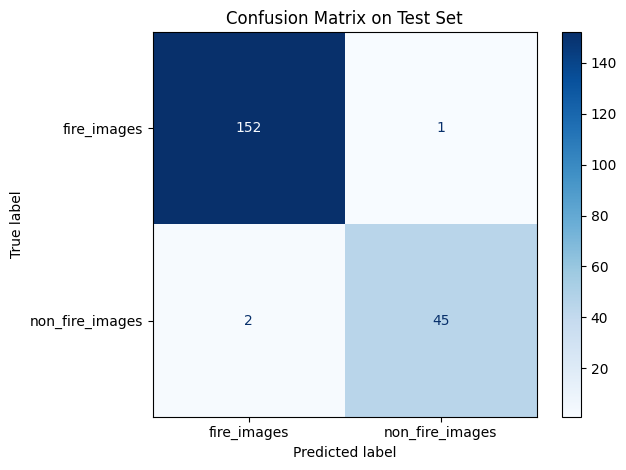

In [15]:
# Confusion Matrix
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)

        preds = outputs.argmax(1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

# Compute and plot confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=full_ds.classes)

plt.figure(figsize=(8, 6))
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix on Test Set")
plt.tight_layout()
plt.show()

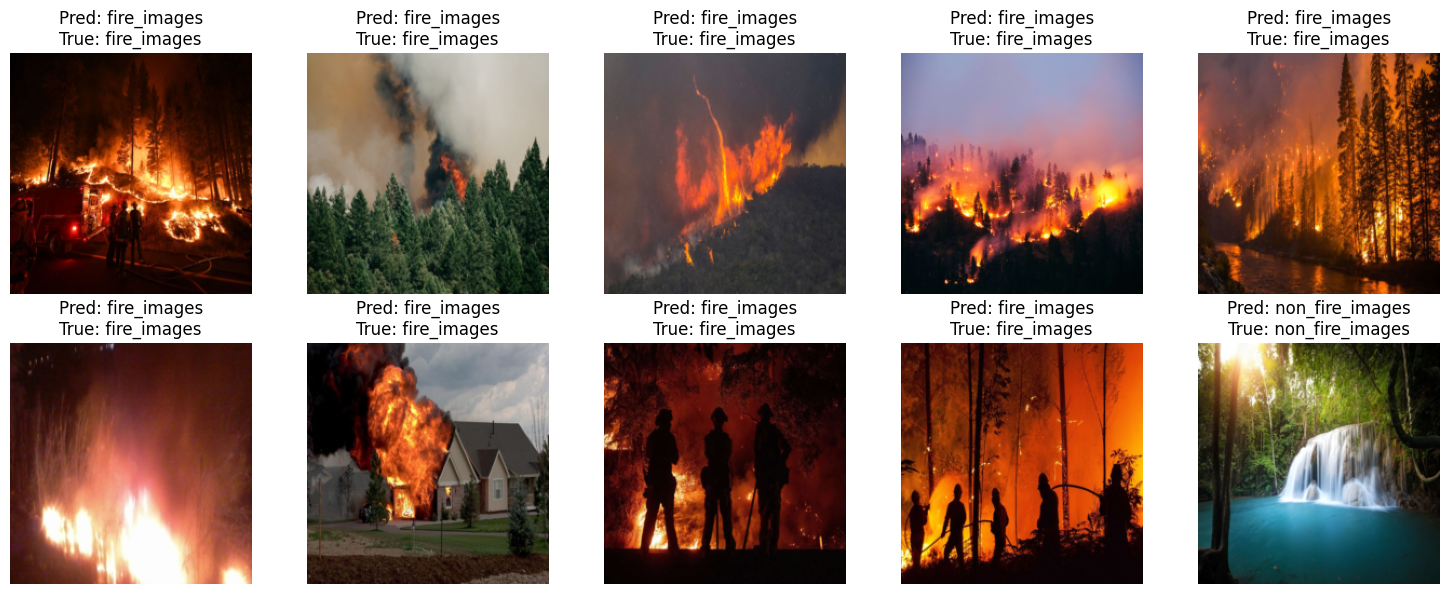

In [16]:
# Show 10 Predictions
def show_predictions(model, dataset, class_names, n=10):
    model.eval()
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    with torch.no_grad():
        for i in range(n):
            img, label = dataset[random.randint(0, len(dataset) - 1)]
            output = model(img.unsqueeze(0).to(device))
            pred = torch.argmax(output, 1).item()
            img_np = img.permute(1, 2, 0).numpy()
            img_np = np.clip(img_np * std + mean, 0, 1)
            ax = axes[i // 5, i % 5]
            ax.imshow(img_np)
            ax.set_title(f"Pred: {class_names[pred]}\nTrue: {class_names[label]}")
            ax.axis("off")
    plt.tight_layout()
    plt.show()

show_predictions(model, val_ds, class_names)

In [17]:
# Export to torchscript
traced_model = torch.jit.trace(model, torch.randn(1, 3, 224, 224).to(device))
traced_model.save("mobilenet_fire_detection_model.pt")
print("TorchScript model saved.")

TorchScript model saved.


In [18]:
# Store all predictions and targets
all_preds = []
all_labels = []
misclassified_imgs = []
misclassified_preds = []
misclassified_true = []

model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # Save misclassified examples
        for i in range(len(preds)):
            if preds[i] != labels[i]:
                misclassified_imgs.append(images[i].cpu())
                misclassified_preds.append(preds[i].item())
                misclassified_true.append(labels[i].item())

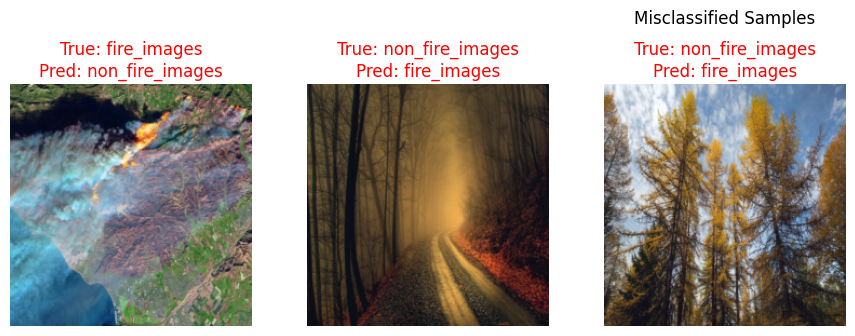

In [19]:
# Identify and visualize misclassified images
def show_misclassified(images, true_labels, pred_labels, class_names, max_display=10):
    plt.figure(figsize=(15, 6))
    for i in range(min(len(images), max_display)):
        img = images[i]
        img = img.permute(1, 2, 0).numpy()
        img = np.clip(img * 0.229 + 0.485, 0, 1)  # De-normalize

        plt.subplot(2, 5, i+1)
        plt.imshow(img)
        plt.title(f"True: {class_names[true_labels[i]]}\nPred: {class_names[pred_labels[i]]}", color="red")
        plt.axis("off")
    plt.suptitle("Misclassified Samples")
    plt.tight_layout()
    plt.show()

# Call the function
show_misclassified(misclassified_imgs, misclassified_true, misclassified_preds, full_ds.classes)

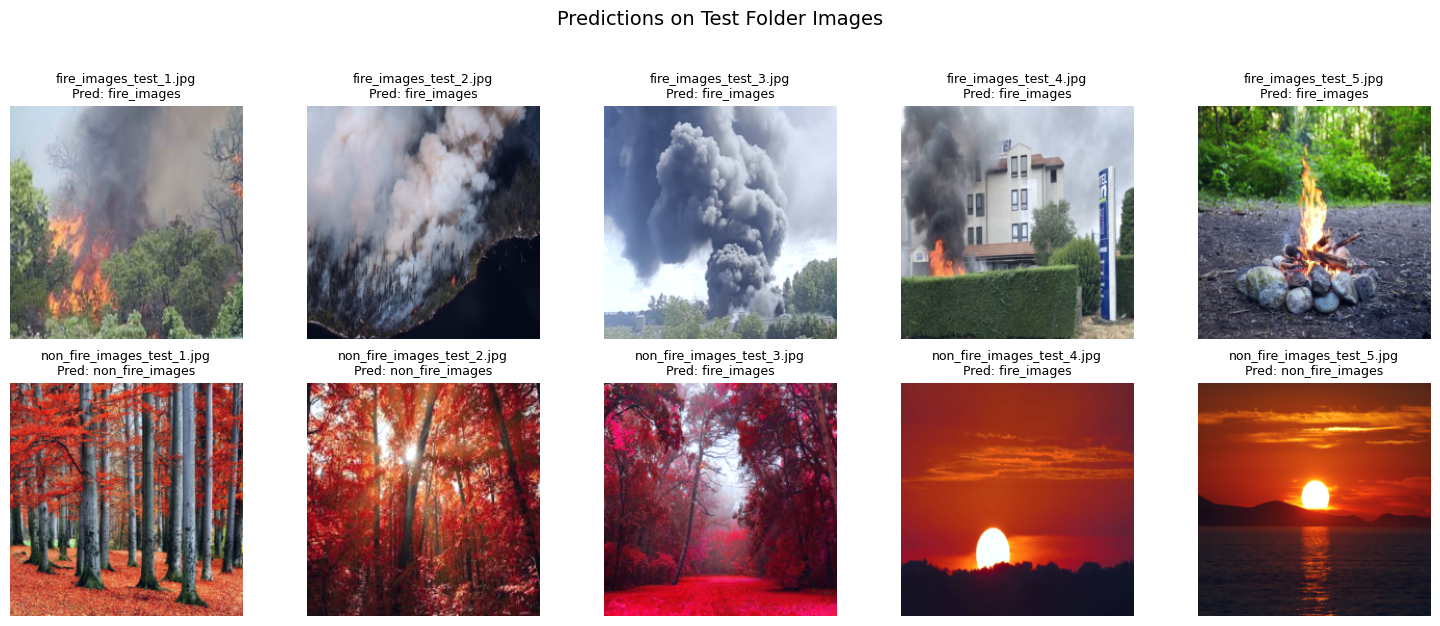

Class Prediction Summary:
  fire_images: 7 images
  non_fire_images: 3 images


In [22]:
# Predictions on new images
def predict_images_in_folder(folder_path, model, transform, class_names, max_display=20):
    model.eval()
    predictions = []
    fig_rows = (max_display + 4) // 5  # Up to 5 images per row
    fig, axes = plt.subplots(fig_rows, 5, figsize=(15, 3 * fig_rows))

    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    image_files = sorted(image_files)[:max_display]  # Limit display

    class_counter = {cls: 0 for cls in class_names}
    for idx, filename in enumerate(image_files):
        path = os.path.join(folder_path, filename)
        try:
            img = Image.open(path).convert("RGB")
            img_tensor = transform(img).unsqueeze(0).to(device)

            with torch.no_grad():
                output = model(img_tensor)
                pred = output.argmax(1).item()
                pred_class = class_names[pred]
                predictions.append((filename, pred_class))
                class_counter[pred_class] += 1

            # Display image
            img_np = transform(img).permute(1, 2, 0).cpu().numpy()
            img_np = np.clip(img_np * 0.229 + 0.485, 0, 1)

            ax = axes[idx // 5, idx % 5]
            ax.imshow(img_np)
            ax.set_title(f"{filename}\nPred: {pred_class}", fontsize=9)
            ax.axis("off")

        except Exception as e:
            print(f"Failed to process {filename}: {e}")

    # Fill empty subplots
    for i in range(len(image_files), fig_rows * 5):
        fig.delaxes(axes[i // 5, i % 5])

    plt.tight_layout()
    plt.suptitle("Predictions on Test Folder Images", fontsize=14)
    plt.subplots_adjust(top=0.9)
    plt.show()

    print("Class Prediction Summary:")
    for cls, count in class_counter.items():
        print(f"  {cls}: {count} images")

    return predictions

# Run
test_folder_path = "./images_test_dataset"
predictions = predict_images_in_folder(test_folder_path, model, val_transform, full_ds.classes)